In [3]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.decomposition import TruncatedSVD

from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.affinity import Affinities

import time
import pickle

import memory_profiler
%load_ext memory_profiler

from pathlib import Path

In [4]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [5]:
variables_path = Path("./data/variables")
figures_path = Path("./viz/embeddings")
embeddings_data_path = Path("data/embeddings/")

In [6]:
# plt.style.use("matplotlib_style.txt")

Pipeline from PubMedBERT embeddings to two dimensional embedding

# Import data

In [7]:
%%time
%%memit
embeddings_reparsed_all = np.load(
    embeddings_data_path
    / "embeddings_microsoft_BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext.npy"
)

peak memory: 359.14 MiB, increment: 115.12 MiB
CPU times: user 68 ms, sys: 29.6 ms, total: 97.6 ms
Wall time: 491 ms


# t-SNE

Annealing exgg=1, n_iter=2000 

## Affinities
- see https://opentsne.readthedocs.io/en/latest/api/affinity.html#openTSNE.affinity.Uniform
- Returns an NxM affinity matrix expressing interactions between N new data points the initial NxM data samples.
- Uniform: Compute affinities using nearest neighbors and uniform kernel in the ambient space.


In [8]:
A = affinity.Uniform(
    embeddings_reparsed_all,
    k_neighbors=10,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

===> Finding 10 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 2.36 seconds


/opt/anaconda3/envs/neurotrial-analysis/lib/python3.12/site-packages/openTSNE/affinity.py:1219: FutureWarning: Using `mean` symmetrization, but the default behaviour is going to change to `max` in future versions.
  warnings.warn(


In [14]:
with open(variables_path / "verbose_tsne_affinities_reparsed.txt", "w") as f:
    f.write(cap.stdout)

In [15]:
# save results
sp.sparse.save_npz(variables_path / "affinities_P_bert_reparsed", A.P)

In [16]:
# load affinities P
affinities_P_bert_reparsed = sp.sparse.load_npz(
    variables_path / "affinities_P_bert_reparsed.npz"
)

In [17]:
# create the affinities object

A = Affinities()
A.P = affinities_P_bert_reparsed

In [18]:
A.P

<19607x19607 sparse matrix of type '<class 'numpy.float64'>'
	with 331955 stored elements in Compressed Sparse Row format>

In [18]:
A.P.shape

(19607, 19607)

## Initialization

In [15]:
%%time
%%memit

I = initialization.pca(embeddings_reparsed_all, random_state=42)

np.save(variables_path / "initialization_bert_reparsed", I)

peak memory: 733.94 MiB, increment: 153.41 MiB
CPU times: user 1.86 s, sys: 731 ms, total: 2.59 s
Wall time: 752 ms


In [16]:
I = np.load(variables_path / "initialization_bert_reparsed.npy")

In [17]:
I.shape

(19607, 2)

## Optimization

In [21]:
Zs = []
kls = []
n_iter = []


def mycallback(iteration, error, embedding):
    Zs.append(embedding.copy())
    kls.append(error)
    n_iter.append(iteration)

In [22]:
%%time

E = TSNEEmbedding(I, A, n_jobs=-1, random_state=42, verbose=True)

# early exaggeration
E = E.optimize(
    n_iter=125,
    exaggeration=12,
    momentum=0.5,
    n_jobs=-1,
    verbose=True,
    callbacks=mycallback,
    callbacks_every_iters=50,
)

# exaggeration annealing
exs = np.linspace(12, 1, 125)
for i in range(125):
    if (i + 1) % 50 == 0:
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=True,
            callbacks=mycallback,
            callbacks_every_iters=1,
        )

    else:
        E = E.optimize(
            n_iter=1,
            exaggeration=exs[i],
            momentum=0.8,
            n_jobs=-1,
            verbose=True,
        )

# final optimization without exaggeration
E = E.optimize(
    n_iter=2000,
    exaggeration=1,
    momentum=0.8,
    n_jobs=-1,
    verbose=True,
    callbacks=mycallback,
    callbacks_every_iters=50,
)

===> Running optimization with exaggeration=12.00, lr=1633.92 for 125 iterations...
Iteration   50, KL divergence 6.9820, 50 iterations in 0.3888 sec
Iteration  100, KL divergence 6.6617, 50 iterations in 0.3834 sec
   --> Time elapsed: 0.97 seconds
===> Running optimization with exaggeration=12.00, lr=1633.92 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.91, lr=1646.09 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.82, lr=1658.44 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.73, lr=1670.97 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.65, lr=1683.70 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.56, lr=1696.63 for 1 iterations...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=11.47, lr=

In [23]:
with open(variables_path / "verbose_tsne_reparsed.txt", "w") as f:
    f.write(cap.stdout)

In [24]:
Zs_array = []
for i in np.arange(len(Zs)):
    Zs_array.append(np.array(Zs[i]))

In [26]:
# save results
f = open(variables_path / "Zs_array_reparsed.pkl", "wb")
pickle.dump(Zs_array, f)
f.close()

In [27]:
# #load
# pickle_in = open( variables_path / "Zs_array_reparsed.pkl","rb")
# Zs_array = pickle.load(pickle_in)

In [28]:
# save iter
f = open(variables_path / "iterations_reparsed.pkl", "wb")
pickle.dump(n_iter, f)
f.close()

In [29]:
# #load
# pickle_in = open( variables_path / "iterations_reparsed.pkl","rb")
# iterations = pickle.load(pickle_in)

In [30]:
# save kl divergence
f = open(variables_path / "kl_divergence_reparsed.pkl", "wb")
pickle.dump(kls, f)
f.close()

In [31]:
# #load
# pickle_in = open( variables_path / "kl_divergence_reparsed.pkl","rb")
# kls = pickle.load(pickle_in)

In [32]:
tsne = np.array(E)

# save
np.save(variables_path / "tsne_reparsed", tsne)

In [33]:
# tsne_reparsed=np.load( variables_path / "tsne_reparsed.npy")

# Plot

In [34]:
tsne.shape

(19607, 2)

In [36]:
tsne

array([[ 41.21494959,  54.03223475],
       [ 43.86070326,  81.41797894],
       [ 43.86070326,  81.41797894],
       ...,
       [ 88.29441623, -13.98527333],
       [ 73.95722409,  -5.43360134],
       [ 43.7250108 ,  16.61028572]])

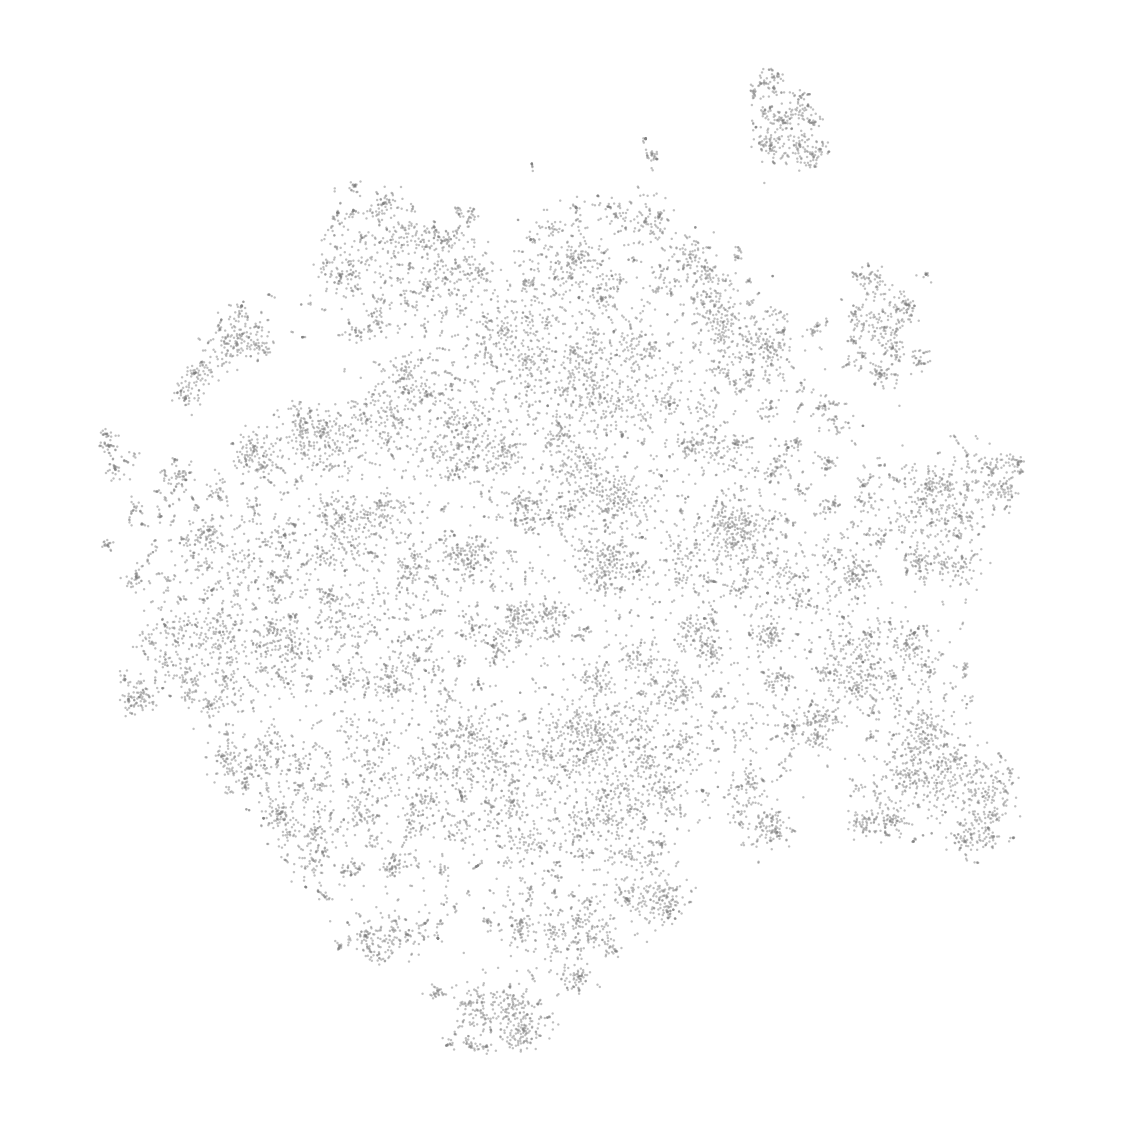

In [39]:
%matplotlib inline

tsne = tsne
fig, ax = plt.subplots(figsize=(5.5, 5.5), dpi=200, layout="constrained")

ax.scatter(
    tsne[:, 0],
    tsne[:, 1],
    s=3,  # Increase size
    c="grey",
    marker=".",
    linewidths=None,
    ec="None",
    alpha=0.5,  # Increase opacity
    rasterized=True,
)

ax.axis("equal")
ax.grid()
# ax.xticks([])
# ax.yticks([])
ax.axis("off")

fig.savefig(figures_path / "tsne_bert_reparsed.png")